# XGBoost

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
#from sklearn.cross_validation import KFold, train_test_split
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

In [1]:
# if to use precalculated pickled models, select True
USE_PRETRAINED = True

# data preprocessing

In [3]:
train = pd.read_csv('./data/train.csv')

# log-transform the loss - target variable
train['log_loss'] = np.log(train['loss'])

# divide categorical and numerical features
features = [x for x in train.columns if x not in ['id', 'loss', 'log_loss']]
cat_features = [x for x in train.select_dtypes(include=['object']).columns 
               if x not in ['id', 'loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(exclude=['object']).columns
               if x not in ['id', 'loss', 'log_loss']]
print('cat_features:', len(cat_features))
print('num_features:', len(num_features))


cat_features: 116
num_features: 14


In [4]:
# use a label encoder for cat_features

ntrain = train.shape[0]
train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes

print('Xtrain:', train_x.shape)
print('ytrain:', train_y.shape)


Xtrain: (188318, 130)
ytrain: (188318,)


# XGBoost with 50 trees (3-fold, early_stopping = 10)

To start with, we train a baseline XGBoost model just to understand how well the whole training goes. As we aren't going to submit the results to Kaggle, we should cross validate them locally. Again, to make sure that an average PC can handle this, we now limit ourselves to 3-fold CV (we'll increase it to 5-fold CV later), 50 trees and stop if a CV error hasn't decreased in 10 rounds.

We use a custom evaluation function xg_eval_mae which calculates MAE, but works with our log-transformed data and uses XGBoost's DMatrix:

In [5]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

# transform the dataset into DMatrix, the native format of XGboost
dtrain = xgb.DMatrix(train_x, train['log_loss'])

# use some average set of parameters
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

In [6]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_bst_cv1.pkl', 'rb') as f:
        bst_cv1 = pickle.load(f)
else:
    bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0,
                    feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
    pck = open('pretrained/xgb_bst_cv1.pkl', 'wb')
    pickle.dump(bst_cv1, pck)
    pck.close()
print('cv scores:', bst_cv1.iloc[-1,:]['test-mae-mean'])

cv scores: 1219.3191326666667
CPU times: user 54.4 s, sys: 1.6 s, total: 56 s
Wall time: 17.7 s


<Figure size 432x288 with 0 Axes>

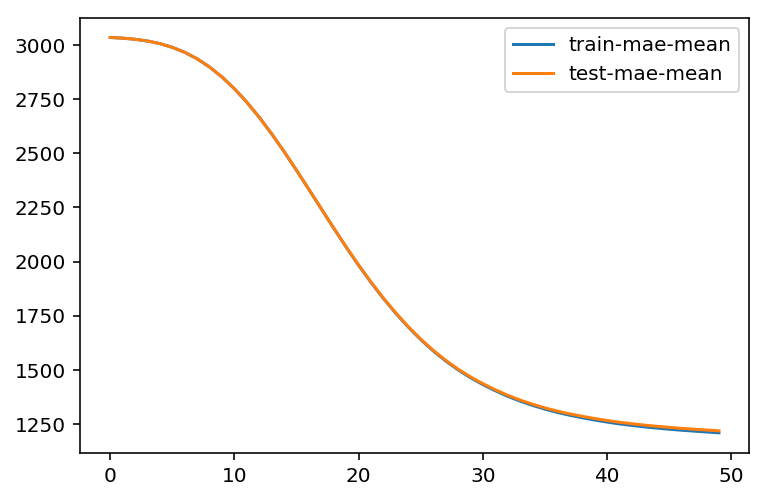

In [7]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

Our first insights from XGBoost:

There is no overfitting, the training and test losses are very close to each other
By the round #50 the loss is still decreasing.
We may safely proceed and train a bit more complex model with 100 trees.

# XGBoost with 100 trees  (3-fold, early_stopping = 10)

In [8]:
%%time
if USE_PRETRAINED:
    with open('pretrained/xgb_bst_cv2.pkl','rb') as f:
        bst_cv2 = pickle.load(f)
else:
    bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=3, seed=0, 
                     feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
    pck = open('pretrained/xgb_bst_cv2.pkl', 'wb')
    pickle.dump(bst_cv2, pck)
    pck.close()
print('cv scores:', bst_cv2.iloc[-1,:]['test-mae-mean'])

cv scores: 1172.833903
CPU times: user 1min 46s, sys: 2.29 s, total: 1min 48s
Wall time: 33.7 s


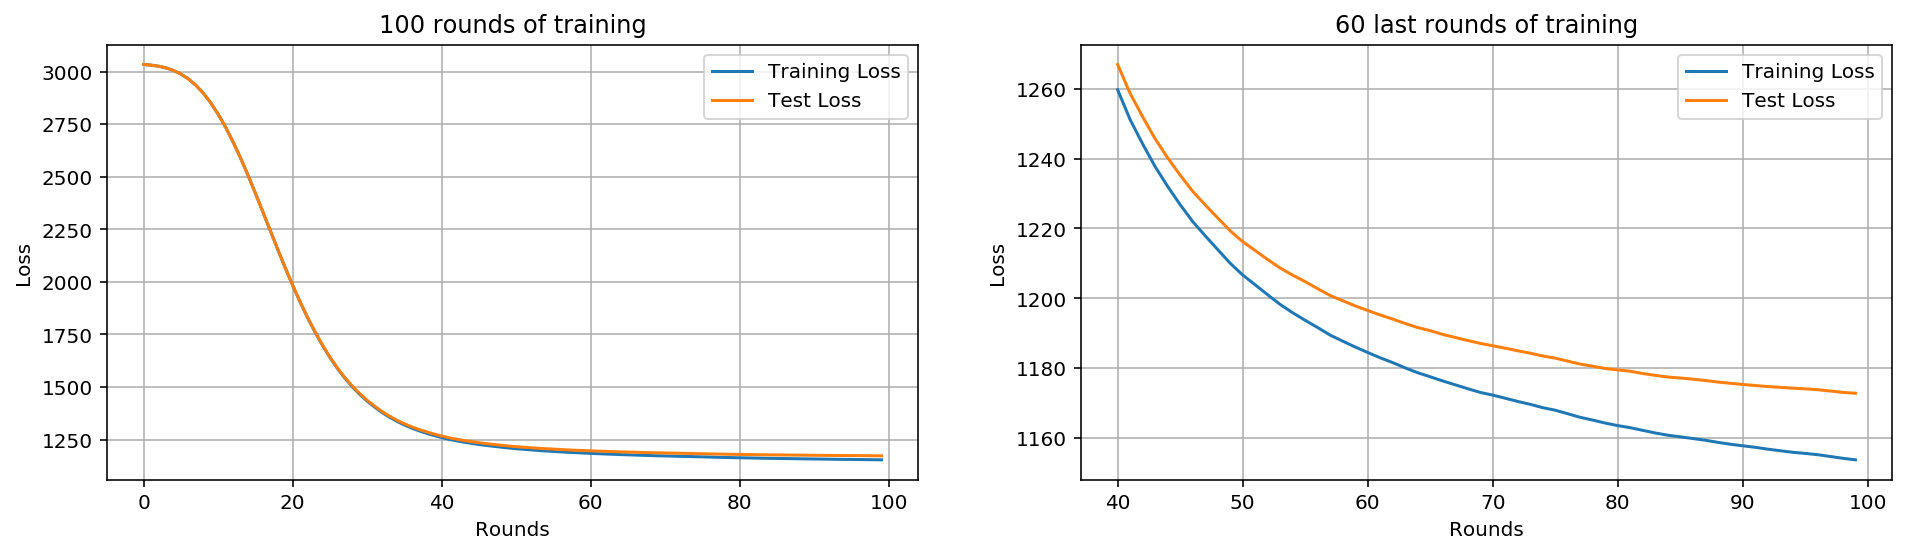

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])


As we see, the gap between training and test loss widens with each new round. While this might not be the best performing model, we are still on the safe side. There is no overfitting, the test loss monotonically decreases with each nwe round.

Now we get a CV score MAE = 1171.77 (CV score: 1171.77067033) which is much better than the score we got first (1219.57). We are now doing better than a baseline model (random forest). Of course, we can increase the number of estimators even further, but we should now concentrate on other hyperparameters and fix num_boost_round till the end of tuning.

When we compete on Kaggle, we usually train complex models (one of my models was an ensemble of 8K trees, another one allowed boosting a very large number of trees, but with early stopping turned on). Outside of competition, we can and should look for a tradeoff between the predictive power and computational complexity of our models.

# XGBoost Tuning

### Methodology

Now we have two models: `bst_cv1` (basic) and `bst_cv2` (with more trees). Again, to simplify and accelerate learning, we go on with the basic model, tune and memorize the hyperparameters and implement a new learner with those hyperparameters based on `bst_cv2`.

The final model will get additional base estimators.

Though we limit our tuning to a grid search, there are much more powerful optimization techniques. One of my favorite is Bayesian global optimization implemented in BayesianOptimization (https://github.com/fmfn/BayesianOptimization) package. This is a smarter and efficient way to find a global extremum (in our case, optimize the hyperparameters space to get the minimum possible MAE) as this algorithm makes intelligent guesses based on past information instead of just exhaustively iterating through the grid.

I suppose that using BayesianOptimization is beyond the scope of this Capstone, so we focus on a grid search approach (which does provide good results). From methodological point of view, we'll use Analytics Vidhya (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) as a reference.

#### Step 1: Set reasonable initial learining rate and a number of estimators.
#### Step 2: Tuning max_depth and min_child_weight.
#### Step 3: Tuning gamma to reduce overfitting.
#### Step 4: Tuning subsample and colsample_bytree.
#### Step 5: Reducing learning rate eta, adding more estimators.


As we use the built-in `GridSearchCV` routine, the simplest way to train XGBoost on it would be to call it via its scikit-learn wrapper interface `xgboost.XGBRegressor`. Unfortunately, it's missing several important properties and functions (e.g. custom eval function or the option to minimize this function instead of maximizing) so we have to write our own wrapper.

In [10]:
# To follow conventional function names in sklearn, we implement fit and predict functions
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [11]:
# We'll also use a custom scorer which works with log-transformed values:

def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))
mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [12]:
%%time
# test the new class

bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, max_depth=5,
                      min_child_weight=3, num_boost_round=50)

bst.kfold(train_x, train_y, nfold=5)

CPU times: user 1min 45s, sys: 3.44 s, total: 1min 49s
Wall time: 33.9 s


#### This looks similar to what we got earlier with 50 trees, so that we are safe to continue.

## Step 1: Fixing learning rate and number of estimators

We've seen from the message above that the CV error hasn't decreased in 10 rounds. This allows us increase the number of num_boost_round, as well as decrease eta, but we now fix these parameters to 50 and 0.1 respectively to reduce training time.

Further on, we return to the discussion of num_boost_round and eta.

## Step 2: Tuning max_depth and min_child_weight

These parameters have the highest impact on the performance of XGBoost, thus, they should be tuned first. We briefly overview them:

max_depth: maximum depth of a tree. Increasing this value will make the model more complex and also prone to overfitting. Recommended depth is between 3-10 which is reasonable: a tree with few levels won't likely to capture non-linear features. On the other hand, too complex tree will probably overfit.
min_child_weight: a regularization parameter. Stops the tree building process if the tree partition results in a leaf node with the sum of instance weight less than defined in min_child_weight. If set too large, a tree may get underfitted.

In [13]:
xgb_param_grid = {'max_depth': range(4,9), 'min_child_weight': (1,3,6)}

In [14]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_max_depth.pkl', 'rb') as f: 
        grid = pickle.load(f)
else:    
    grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
    grid.fit(train_x, train_y.values)
    pck = open('pretrained/xgb_grid_max_depth.pkl', 'wb')
    pickle.dump(grid, pck)
    pck.close()

CPU times: user 32min 51s, sys: 1min 42s, total: 34min 34s
Wall time: 11min 53s


In [15]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1242.18423, std: 6.49856, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -1241.95481, std: 6.34385, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -1242.35685, std: 6.55838, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -1218.28642, std: 6.39532, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -1217.74071, std: 7.34767, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -1217.55438, std: 7.03312, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -1204.13766, std: 6.96746, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -1203.51865, std: 7.27812, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -1203.04238, std: 7.17762, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -1194.15390, std: 7.63983, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -1193.57568, std: 6.98910, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -1193.11751, std: 7.34072, params: {'max_depth': 7, 'min_child_weigh

#### The best result found by this grid search:

#### {'max_depth': 8, 'min_child_weight': 6},
#### -1186.9218564129187)

A negative value is a convention of GridSearchCV (always search for a maximum).

To understand the relationship between max_depth and min_child_weight, we draw a contour plot. First, we facilitate retrieving data from grid.grid_scores_:

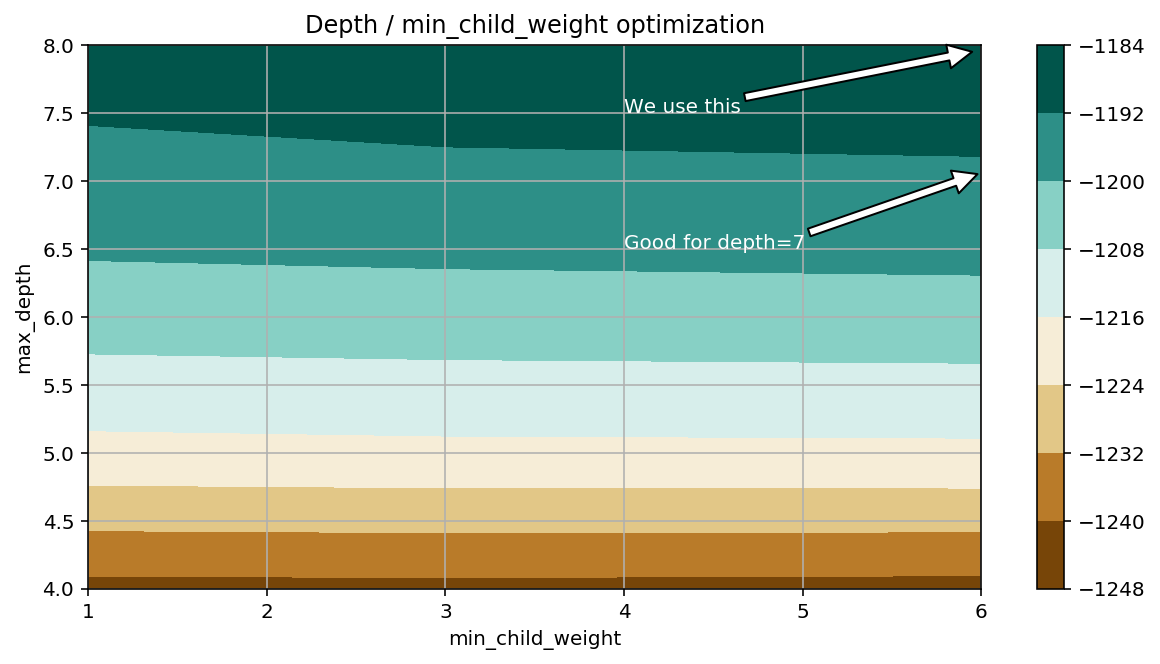

In [16]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

#_, _, scores =  convert_grid_scores(grid.grid_scores_)
_, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

As we see from the results of grid search, the improvement of score is mostly based on the increase of max_depth (the bars on the contour plot are mostly horizontal). min_child_weight only slightly influence the score, though, we see that min_child_weight=6 usually works good.

One more peculiar observation we may have is that the increase of min_child_weight starts to make sense when max_depth grows. We can compensate a smaller value of max_depth (8 -> 7) by setting min_child_weight=6 and still get a good score. Thus we optimize the speed of our regressor for production use.


# Step 3: Tuning gamma to reduce overfitting 
### with 'max_depth': 8, 'min_child_weight': 6

Now we continue our grid search and start tuning gamma. We also take the parameters already tuned above. Adding gamma means that the model now requires a minimum amount of loss reduction to make a further partition.

Let's make a grid search to find an optimal gamma. Though our model doesn't seem to suffer from overfitting, tuning gamma is very important and it's a requirement for more complicated models.

In [17]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_gamma.pkl', 'rb') as f: 
        grid = pickle.load(f)
    
else:
    xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

    grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.5, subsample=0.5),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

    grid.fit(train_x, train_y.values)
    pck = open('pretrained/xgb_grid_gamma.pkl', 'wb')
    pickle.dump(grid, pck)
    pck.close()

CPU times: user 14min 48s, sys: 38.9 s, total: 15min 26s
Wall time: 4min 46s


In [18]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1186.92186, std: 6.86894, params: {'gamma': 0.0},
  mean: -1187.06307, std: 6.66021, params: {'gamma': 0.1},
  mean: -1187.07522, std: 7.06925, params: {'gamma': 0.2},
  mean: -1187.89525, std: 7.19206, params: {'gamma': 0.30000000000000004},
  mean: -1186.97153, std: 7.76354, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -1186.9218564129187)

# got different results on different machines 
### hard to say whether we should pick one or the other.

### The conclusion here is to always check your model for overfitting
### Further on, we'll use gamma=0.1.

# Step 4: Tuning subsample and colsample_bytree

Each single tree in XGBoost is usually trained on a subset of data. subsample defines a subsample ratio of training examples per tree, colsample_bytree — a subsample ratio of columns when constructing each tree.

Though Kaggle competitors prefer using a small value of colsample_bytree, we are going to abide by our methodology and test larger values of colsample_bytree. Of course, we may test smaller values, find another local optima and stack several prominent XGBoost models with different colsample_bytree or subsample values into one ensemble.

In [19]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(5,10)],
                      'colsample_bytree':[ 0.1 * i for i in range(5,10)]}

if USE_PRETRAINED: 
    with open('pretrained/xgb_grid_search_sampling.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.1, num_boost_round=50, max_depth=8, min_child_weight=6),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
    grid.fit(train_x, train_y.values)
    pck = open('pretrained/xgb_grid_search_sampling.pkl', 'wb')
    pickle.dump(grid, pck)
    pck.close()

CPU times: user 1h 26min 25s, sys: 3min 14s, total: 1h 29min 40s
Wall time: 27min 36s


In [20]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1187.06307, std: 6.66021, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: -1184.58471, std: 6.46272, params: {'colsample_bytree': 0.5, 'subsample': 0.6000000000000001},
  mean: -1184.39189, std: 6.77201, params: {'colsample_bytree': 0.5, 'subsample': 0.7000000000000001},
  mean: -1183.67153, std: 6.23269, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: -1184.00984, std: 6.39219, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: -1185.78872, std: 6.35010, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.5},
  mean: -1185.19713, std: 6.12721, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.6000000000000001},
  mean: -1184.50301, std: 6.61742, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001},
  mean: -1183.92140, std: 6.69612, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.8},
  mean: -1183.66745, std: 6.12448, params: {'colsample_bytree': 0.6000000000000001, 'sub

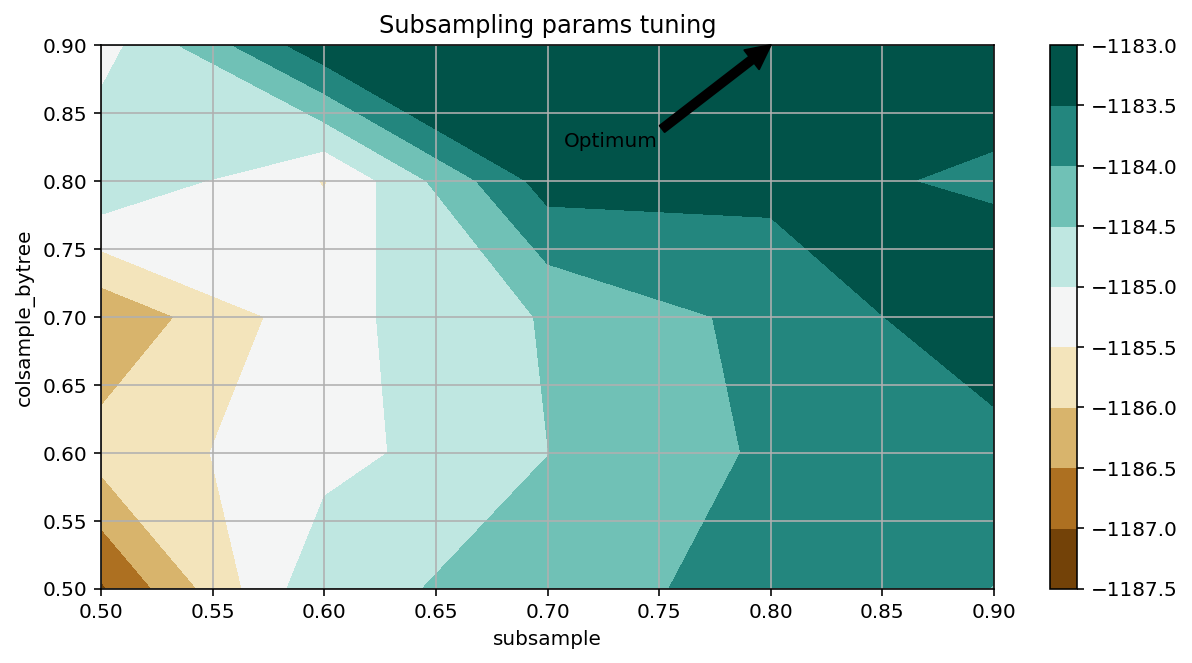

In [28]:
_, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,5)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.8, 0.9), xytext=(0.7075, 0.825), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

In the specific case of current pretrained model, I got the following results:

{'colsample_bytree': 0.9, 'subsample': 0.6000000000000001},
 -1183.14716)

Considering (0.6, 0.9) is close to the high error region, for the following steps, I select this point:

#### -1183.16503, 'colsample_bytree': 0.9, 'subsample': 0.8



# Step 5: Reducing learning rate and adding more trees

The final step in our parameters optimization will be to reduce learning rate and add more estimators at the same time. There is a very good discussion on Kaggle regarding interpretation of learning rate and its relation to the amount of training rounds (which is basically the number of trees we throw at the problem).

What eta and num_boost_round should we choose? A trivial answer would be to pick several desired learning rates possible and do grid search with several possible values of num_boost_round. This is very costly in practice. Alternatively, we can test a few num_boost_round candidates and understand when and how the shrinkage of eta starts to affect the score. Thus, we can generalize a rule of thumb: what eta should be set for the current num_boost_round.

We have two options for num_boost_round (as we discussed at the start of this analysis): 50 and 100 trees: num_boost_round=[50, 100]. We choose several eta for each of them: eta=[0.2,0.1,0.075,0.05,0.04,0.03,0.02,0.01].

### First, we plot different learning rates for a simpler model (50 trees):

In [32]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_50.pkl', 'rb') as f:
        grid = pickle.load(f)
else:      
    xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.1, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.9, subsample=0.8),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

    grid.fit(train_x, train_y.values)
    pck = open('pretrained/xgb_grid_search_eta_50.pkl', 'wb')
    pickle.dump(grid, pck)
    pck.close()

CPU times: user 36min 50s, sys: 1min 18s, total: 38min 9s
Wall time: 12min 29s


In [33]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1212.41782, std: 7.05587, params: {'eta': 0.5},
  mean: -1187.92969, std: 6.20391, params: {'eta': 0.4},
  mean: -1173.75544, std: 6.00868, params: {'eta': 0.3},
  mean: -1161.00016, std: 7.60289, params: {'eta': 0.2},
  mean: -1183.16503, std: 6.69449, params: {'eta': 0.1},
  mean: -1264.73885, std: 7.27819, params: {'eta': 0.075},
  mean: -1705.67724, std: 8.29759, params: {'eta': 0.05},
  mean: -2101.21905, std: 8.08093, params: {'eta': 0.04},
  mean: -2543.54126, std: 7.81762, params: {'eta': 0.03}],
 {'eta': 0.2},
 -1161.0001601152856)

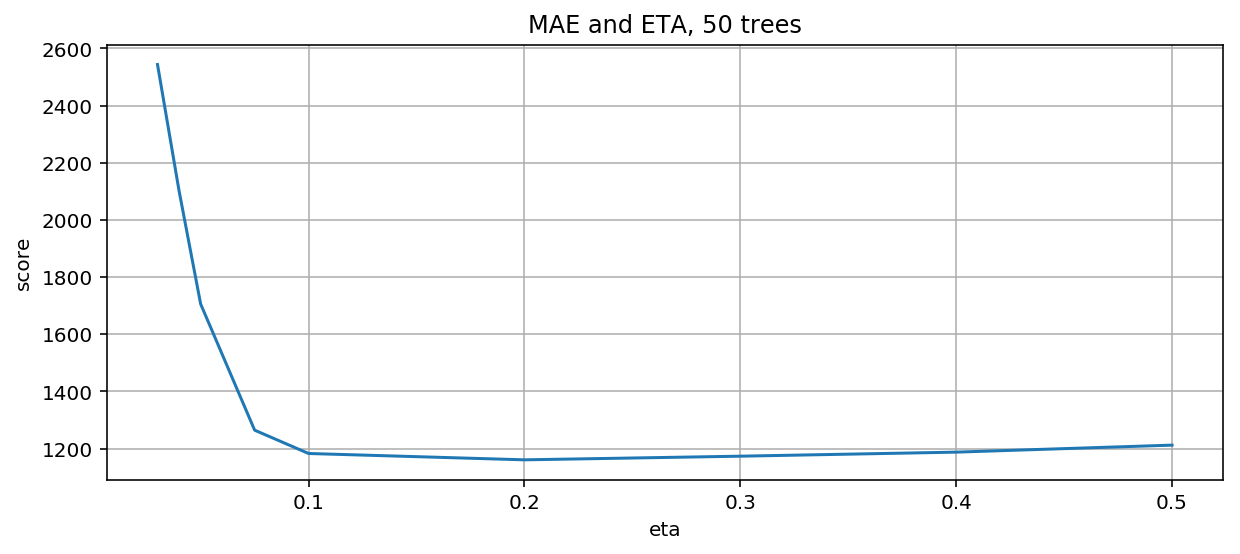

In [34]:
_, y = convert_grid_scores(grid.grid_scores_)
eta = [0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

Observing the curve, we understand that eta < 0.1 doesn't allow the model reach a decent score. In this case, the step would be too small for only 50 trees we have at this time.

We also see that we missed the correct eta: instead of 0.1 it should be near 0.2. We won't finetune it further, though. Instead, let's memorize that 
#### for num_boost_round=50 we found eta=0.2. 
As we see,  {'eta': 0.2}, -1161.0001601152856) improved our score for the same small amount of trees.

Now, replicate the process for num_boost_round=100. We effectively double the amount of trees, let's see how eta should be changed.

### num_boost_round=100 (double the amount of trees)

In [35]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_100.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.1, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.9, subsample=0.8),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

    grid.fit(train_x, train_y.values)
    pck = open('pretrained/xgb_grid_search_eta_100.pkl', 'wb')
    pickle.dump(grid, pck)
    pck.close()

CPU times: user 1h 12min 21s, sys: 1min 48s, total: 1h 14min 10s
Wall time: 23min 13s


In [36]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1242.77340, std: 7.00829, params: {'eta': 0.5},
  mean: -1208.48525, std: 5.23696, params: {'eta': 0.4},
  mean: -1182.34929, std: 5.29618, params: {'eta': 0.3},
  mean: -1161.09798, std: 8.17562, params: {'eta': 0.2},
  mean: -1152.19615, std: 6.32877, params: {'eta': 0.1},
  mean: -1157.37623, std: 4.88644, params: {'eta': 0.075},
  mean: -1184.04380, std: 6.49456, params: {'eta': 0.05},
  mean: -1242.27167, std: 6.94336, params: {'eta': 0.04},
  mean: -1463.58363, std: 8.24685, params: {'eta': 0.03}],
 {'eta': 0.1},
 -1152.1961534717714)

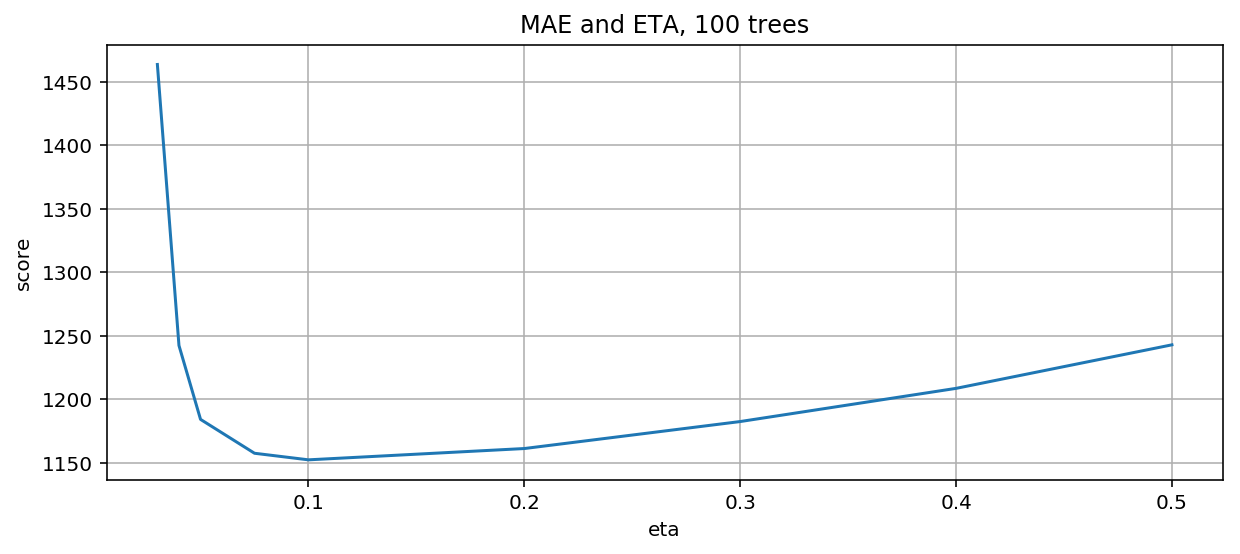

In [37]:
_, y = convert_grid_scores(grid.grid_scores_)
eta = [0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

We now see that the optimal eta=0.1 and we conclude that doubling the amount of estimators should come with cutting eta in half. Of course, this is just a rule of thumb and the real dependency is not a linear one (and not that trivial), but such a rule can work as an educated guess for future models.

Let's train one more XGBoost with just a few eta values to confirm this assumption.

In [38]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_200.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.1, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.9, subsample=0.8),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

    grid.fit(train_x, train_y.values)
    pck = open('pretrained/xgb_grid_search_eta_200.pkl', 'wb')
    pickle.dump(grid, pck)
    pck.close()

CPU times: user 1h 36min 38s, sys: 1min 46s, total: 1h 38min 24s
Wall time: 29min 49s


In [39]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1146.47968, std: 5.70694, params: {'eta': 0.09},
  mean: -1147.47662, std: 6.89260, params: {'eta': 0.08},
  mean: -1147.22739, std: 6.92503, params: {'eta': 0.07},
  mean: -1147.52649, std: 5.76795, params: {'eta': 0.06},
  mean: -1148.31745, std: 6.19444, params: {'eta': 0.05},
  mean: -1152.81455, std: 5.96486, params: {'eta': 0.04}],
 {'eta': 0.09},
 -1146.4796782914564)

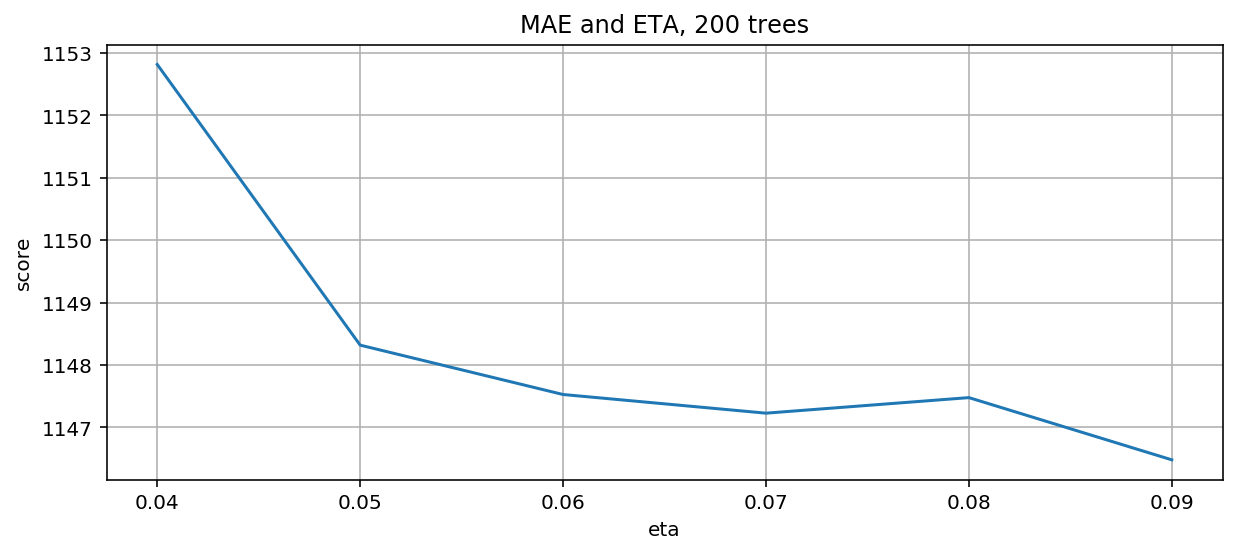

In [40]:
_, y = convert_grid_scores(grid.grid_scores_)
eta = [0.09,0.08,0.07,0.06,0.05,0.04]
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [41]:
%%time

# Final XGBoost model

if USE_PRETRAINED:
    with open('pretrained/xgb_cv_eta_200_0_09.pkl', 'rb') as f:
        cv = pickle.load(f)
else:
    bst = XGBoostRegressor(num_boost_round=200, eta=0.09, gamma=0.1, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.9, subsample=0.8)
    cv = bst.kfold(train_x, train_y, nfold=5)
    pck = open('pretrained/xgb_cv_eta_200_0_09.pkl', 'wb')
    pickle.dump(grid, pck)
    pck.close()

CPU times: user 15min 26s, sys: 15.9 s, total: 15min 42s
Wall time: 4min 58s


In [42]:
cv

train-mae-mean     1016.840466
train-mae-std         1.950209
train-rmse-mean       0.486213
train-rmse-std        0.000413
test-mae-mean      1147.667529
test-mae-std          8.323997
test-rmse-mean        0.538188
test-rmse-std         0.002391
Name: 199, dtype: float64

We see that the best eta for 200 trees is 0.08. As we expected, dependency between eta and num_boost_round is not linear.

It took us quite a while to optimize XGBoost. Let's recall the initial score: 1219.3191326666667. After doing grid search, this model (with fixed eta and num_boost_round) scored MAE=1172.833903.

We also found out the relationship between eta and num_boost_round and progressively trained two more models:

100 trees, eta=0.1: MAE=1152.1836847205736
200 trees, eta=0.08: MAE=1145.127783
We now found our first model we can use in the final ensemble. Here it is: XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.08). CV score for the final run of this model: MAE=1146.998. As we see, results may fluctuate quite a bit.

Room for Improvement
Though we improved our score, there is still a great potential to get even better results. I'll just list some of them:

Fit a more complex XGBoost model by adding even more estimators and reducing eta at the same time.
Use early_stopping_rounds instead of num_boost_round to limit the training. In this case, we set eta to the a small number and make num_boost_round very large (up to 100K).
Run Grid Search on different values of hyperparameters. Say, we could test 0 < colsample_bytree < 0.5 which often fruits good results. The idea is that there is a number of local optima in the hyperparameters space and we should find several of these optima.
Ensemble several XGBoost models, trained with different hyperparameters. This can be done by bagging (averaging the score of the models), blending and stacking.